# Import

In [14]:
import pandas
import sklearn.ensemble
from sklearn.ensemble import GradientBoostingClassifier
import evaluation

# Read training data

In [15]:
folder = 'C:/MSDS/Proj/flav/'
df = pandas.read_csv(folder + 'training.csv', index_col='id')

In [16]:
df.head()

,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,DOCAtwo,...,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits,production,signal,mass,min_ANNmuon
id,,,,,,,,,,,,,,,,,,,,,
18453471,0.001578,0.999999,14.033335,0.681401,0.016039,0.451886,1.900433,1482.037476,0.066667,0.060602,...,12290.760742,39264.398438,3.076006,4.003800,4.031514,458,-99,0,1866.300049,0.277559
5364094,0.000988,0.999705,5.536157,0.302341,0.142163,9.564503,0.865666,3050.720703,0.024022,0.019245,...,16562.667969,7341.257812,3.228553,2.786543,2.975564,406,-99,0,1727.095947,0.225924
11130990,0.000877,0.999984,6.117302,0.276463,0.034746,1.970751,10.975849,3895.908691,0.055044,0.047947,...,22695.388672,10225.309570,3.536903,2.865686,3.052810,196,-99,0,1898.588013,0.368630
15173787,0.000854,0.999903,5.228067,0.220739,0.076389,4.271331,3.276358,4010.781738,0.053779,0.006417,...,16909.515625,9141.426758,3.087461,3.218034,2.375592,137,-99,0,1840.410034,0.246045
1102544,0.001129,0.999995,39.069534,1.898197,0.120936,4.984982,0.468348,4144.546875,0.004491,0.037326,...,97612.804688,47118.785156,4.632295,4.711155,4.296878,477,-99,0,1899.793945,0.222060


In [ ]:
df.info()

# Define training features
Here we use subset of the all features to pass the agreement checking

In [17]:
variables = ['dira',
             'pt',
             'LifeTime',
             'VertexChi2',
             'IP',
             'iso',
             'ISO_SumBDT'             
             ]

# Baseline training

In [18]:
baseline = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, subsample=0.4,
                                      min_samples_leaf=10, max_depth=10, random_state=11)
baseline.fit(train[variables], train['signal'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=10,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=500, presort='auto', random_state=11,
              subsample=0.4, verbose=0, warm_start=False)

In [27]:
#save these arrays as pickle files in case kernel stops
import pickle
output = open('grade999.pkl', 'wb')
pickle.dump(baseline, output)

In [28]:
output.close()

In [31]:
#load saved file
decision_tree_model_pkl = open('grade999.pkl', 'rb')
decision_tree_model = pickle.load(decision_tree_model_pkl)
print(decision_tree_model)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=10,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=500, presort='auto', random_state=11,
              subsample=0.4, verbose=0, warm_start=False)


[ 0.12  0.16  0.16  0.17  0.2   0.03  0.16]


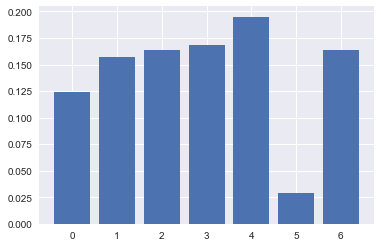

In [57]:
import xgboost
model = baseline
print(baseline.feature_importances_)
from numpy import loadtxt
from xgboost import XGBClassifier
from matplotlib import pyplot
# load data

# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

In [59]:
plot_importance(model)
pyplot.show()

NameError: name 'plot_importance' is not defined

# Check agreement test

In [19]:
check_agreement = pandas.read_csv(folder + 'check_agreement.csv', index_col='id')
agreement_probs = baseline.predict_proba(check_agreement[variables])[:, 1]

ks = evaluation.compute_ks(
    agreement_probs[check_agreement['signal'].values == 0],
    agreement_probs[check_agreement['signal'].values == 1],
    check_agreement[check_agreement['signal'] == 0]['weight'].values,
    check_agreement[check_agreement['signal'] == 1]['weight'].values)
print('KS metric', ks, ks < 0.09)


KS metric 0.0371037487254 True


# Check correlation test

In [20]:
check_correlation = pandas.read_csv(folder + 'check_correlation.csv', index_col='id')
correlation_probs = baseline.predict_proba(check_correlation[variables])[:, 1]
cvm = evaluation.compute_cvm(correlation_probs, check_correlation['mass'])
print ('CvM metric', cvm, cvm < 0.002)

CvM metric 0.000963820271556 True


# Compute weighted AUC on the training data with min_ANNmuon > 0.4

In [21]:
train_eval = train[train['min_ANNmuon'] > 0.4]
train_probs = baseline.predict_proba(train_eval[variables])[:, 1]
roc_auc = evaluation.roc_auc_truncated(train_eval['signal'], train_probs)
print( 'AUC', roc_auc)

AUC 0.999858748749


In [34]:
jtrn = train_eval['signal']

In [40]:
import numpy as np
#print(train_probs)

confm_probs2 = np.round(train_probs, decimals=0)
#print(confm_probs)

from sklearn.metrics import confusion_matrix
conf=confusion_matrix(train_eval['signal'], confm_probs)

print(conf)




[[ 7366   433]
 [  234 29979]]


Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[ 7366   433]
 [  234 29979]]


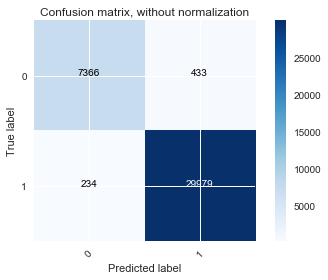

In [48]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf, classes='01',
                      title='Confusion matrix, without normalization')


Normalized confusion matrix
[[ 0.94  0.06]
 [ 0.01  0.99]]


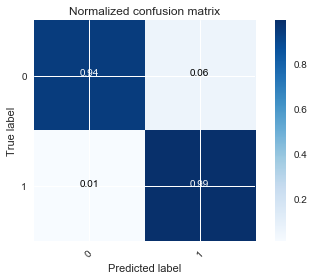

In [49]:
plt.figure()
plot_confusion_matrix(conf, classes='01', normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Predict test, create file for kaggle

In [50]:
test = pandas.read_csv(folder + 'test.csv', index_col='id')
result = pandas.DataFrame({'id': test.index})
result['prediction'] = decision_tree_model.predict_proba(test[variables])[:, 1]

In [51]:
result.to_csv('JHbaseline.csv', index=False, sep=',')

In [52]:
ls -l baseline.csv

 Volume in drive C is Windows
 Volume Serial Number is 1C17-4C29

 Directory of C:\MSDS\Proj\flavours-of-physics-start-master


 Directory of C:\MSDS\Proj\flavours-of-physics-start-master

10/01/2018  11:07 PM        24,671,773 baseline.csv
               1 File(s)     24,671,773 bytes
               0 Dir(s)  80,393,232,384 bytes free


In [53]:
result.to_csv?

In [ ]:
?ls